In [26]:
from epydemix.model import EpiModel
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles
import numpy as np

# Modeling Multiple Strains 

In this tutorial, we will model the spread of two strains of a pathogen using a simple SIR-like model. More specifically, we will model the emergence of a second, more transmissible strain following the initial outbreak caused by the first strain. The transitions of the model are shown below: 

$$S + I_1 \rightarrow_{\beta} 2I_1$$

$$S + I_2 \rightarrow_{\beta \psi} 2I_2$$

$$R_1 + I_2 \rightarrow_{\beta \psi \gamma} 2I_2$$

$$I_1 \rightarrow_{\mu_1} R_1$$

$$I_2 \rightarrow_{\mu_2} R_2$$

In other words, the second strain is $\psi$ times more transmissible than the first strain (i.e., $\psi=1.5$ means that the second strain is 50% more transmissible than the first strain). Additionally, protection against the second strain provided by infection with the first strain is only partial, and $R_1$ individuals can still get reinfected by the second strain, with a rate regulated by $\gamma$, which quantifies the relative susceptibility of $R_1$ individuals to the second strain (i.e., $\gamma=1.$ means that $R_1$ individuals are completely susceptible to the second strain).

We initialize the model in epydemix defining the compartments and the transitions: 


In [27]:
model = EpiModel(compartments=["S", "I1", "I2", "R1", "R2"])

# S + I1 -> 2 I1
model.add_transition(source="S", target="I1", kind="mediated", params=("beta", "I1"))

# S + I2 -> 2 I2
model.add_transition(source="S", target="I2", kind="mediated", params=("beta*psi", "I2"))

# R1 + I2 -> 2 I2
model.add_transition(source="R1", target="I2", kind="mediated", params=("beta*psi*gamma", "I2"))

# I1 -> R1
model.add_transition(source="I1", target="R1", kind="spontaneous", params="mu1")

# I2 -> R2
model.add_transition(source="I2", target="R2", kind="spontaneous", params="mu2")

Next, we set the parameter values. We imagine that the second strain emerges following a period of time in which the first strain is the only one circulating. In order to account for this, we override the parameters of the second strain by setting both $\psi$ and $\mu_2$ to $0$, during this initial period. This a practical way to account for the fact that the second strain is not present in the population at the beginning of the outbreak, but individuals initialized in $I_2$ only become _active_ (i.e., they can infect and recover) after a certain period of time. 

We also assume that the second strain is $50\%$ more transmissible than the first strain, that $R_1$ individuals are $60\%$ less susceptible to the second strain with respect to $S$ individuals, and that the two strains have the same recovery rate. 

In [28]:
# Set parameter values 
model.add_parameter(parameters_dict={"beta": 0.2, 
                                     "psi": 1.5, 
                                     "mu1": 0.1, 
                                     "mu2": 0.1, 
                                     "gamma": 0.4})

# Override the parameters of the second strain to simulate its later emergence 
model.override_parameter(start_date="2025-01-01",
                         end_date="2025-02-01",
                         parameter_name="psi", 
                         value=0.0)

model.override_parameter(start_date="2025-01-01",
                         end_date="2025-02-01",
                         parameter_name="mu2", 
                         value=0.0)

Finally, we simulate the model over a period of 6 months, with an initial condition in which 20 individuals are initialized in each compartment infected compartmets

In [31]:
# simulate 
results = model.run_simulations(start_date="2025-01-01", 
                                end_date="2025-07-31", 
                                initial_conditions_dict={"S": model.population.Nk - np.ones(1)*20, 
                                                         "I1": np.ones(1)*10,
                                                         "I2": np.ones(1)*10, 
                                                         "R1": np.zeros(1),
                                                         "R2": np.zeros(1)})

Finally, we retrieve and plot the evolution of the number of individuals in each infected compartment over time. 

<Axes: >

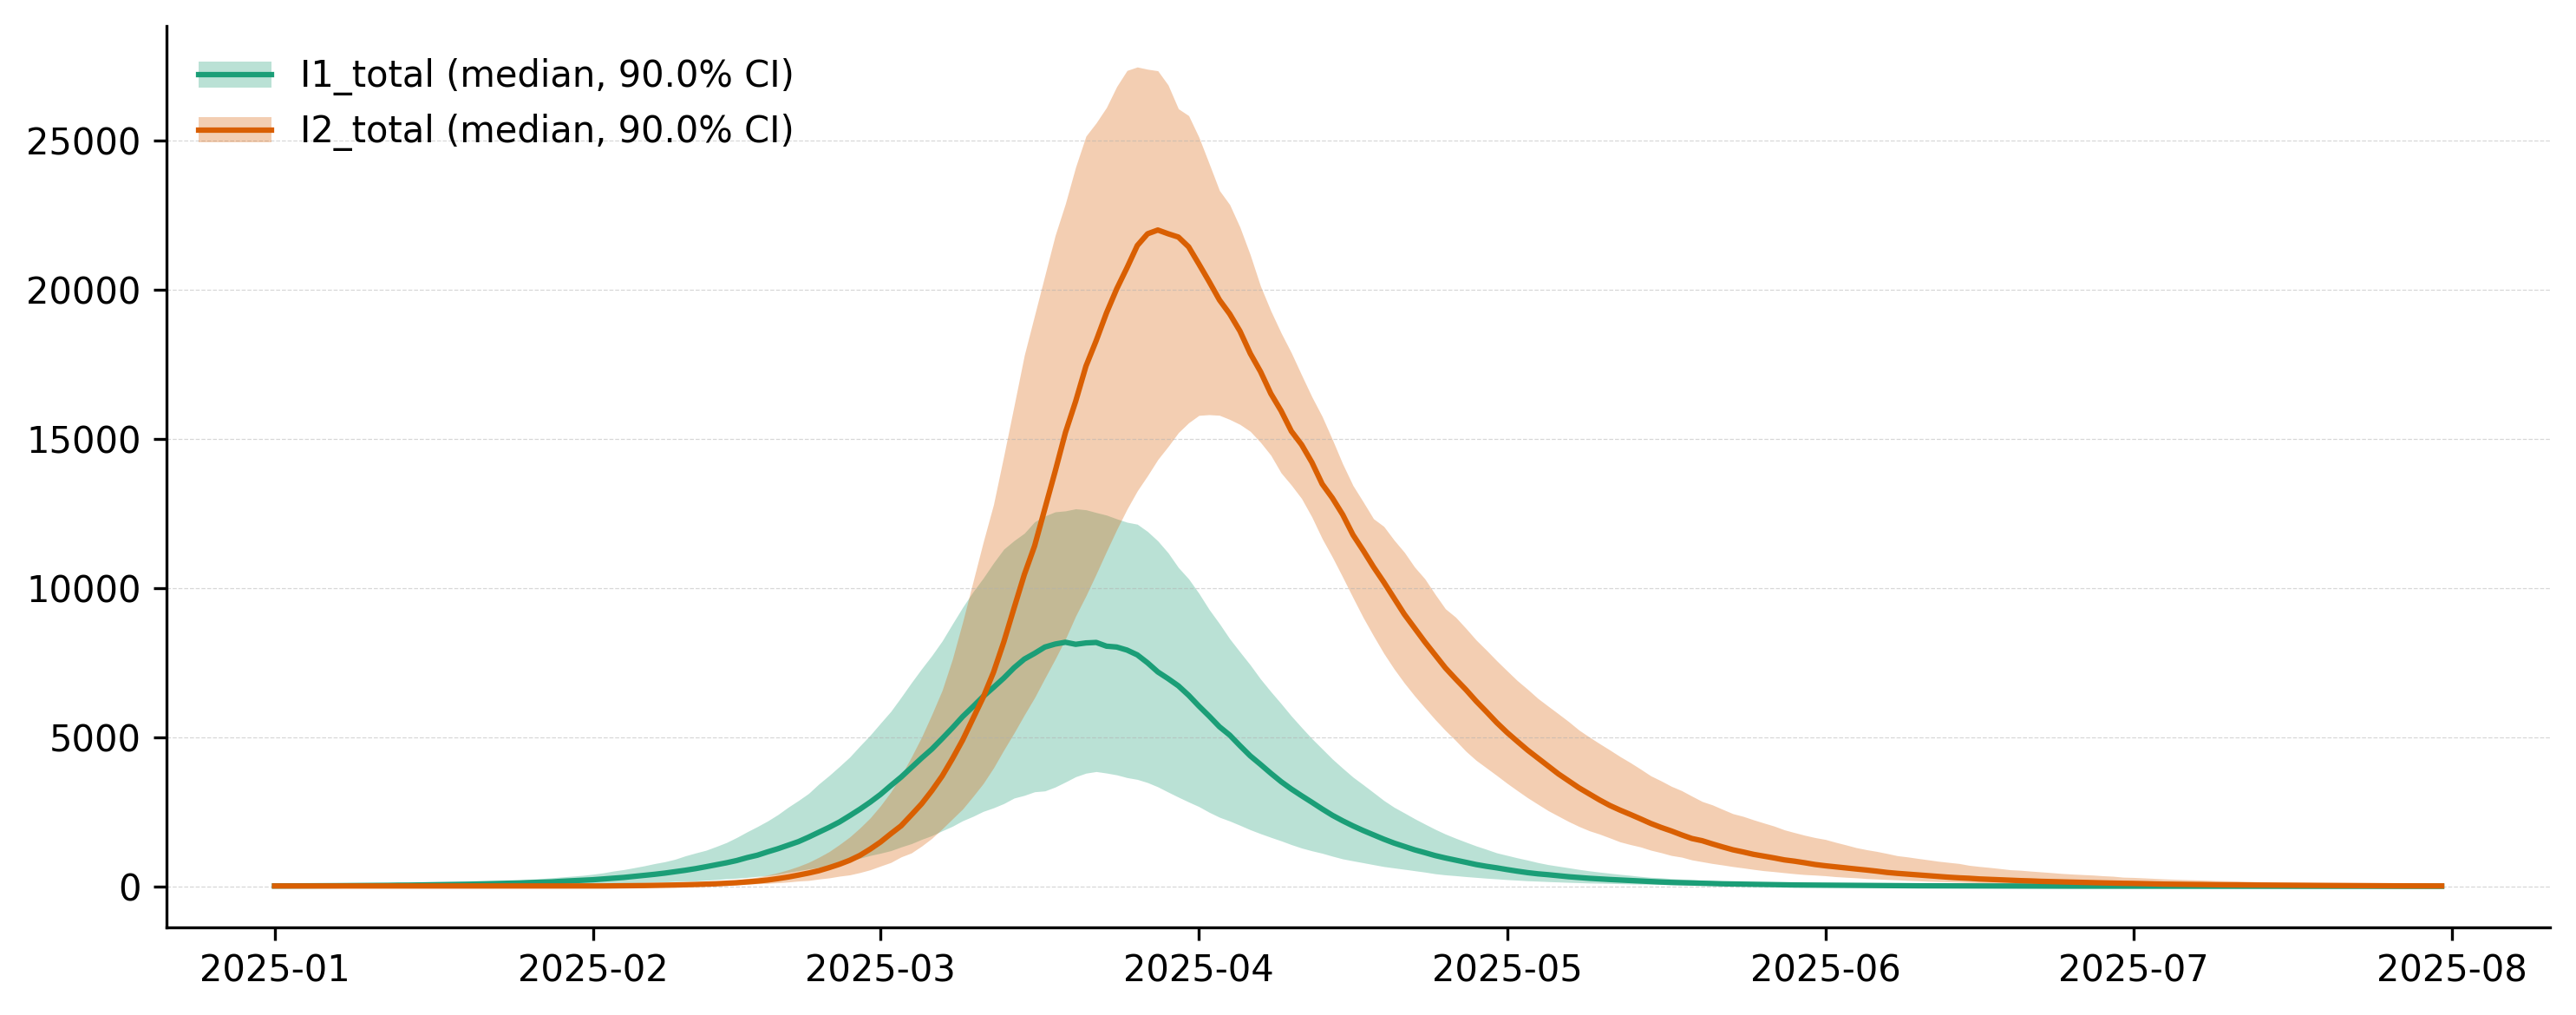

In [32]:
df_compartments = results.get_quantiles_compartments()
plot_quantiles(df_compartments, columns=["I1_total", "I2_total"])